# STILL NONSENSE TESTING - IGNORE 

In [18]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dag_prf_utils.plot_functions import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate data

In [19]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
paradigm = np.vstack([sfs_seq, con_seq])


In [20]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [21]:
parameters = pd.DataFrame({
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  0.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amplitude'         : np.array([   1.00,   1.00,   1.00,   2.00,]), # [fMRI parameters]
    'baseline'          : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    # 'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    # 'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }).astype('float32')



In [22]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

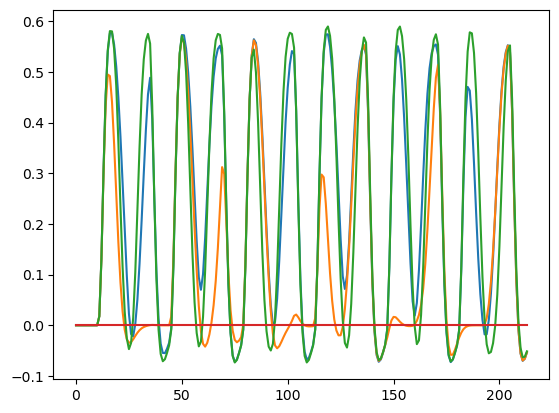

In [23]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

# Classic fitter

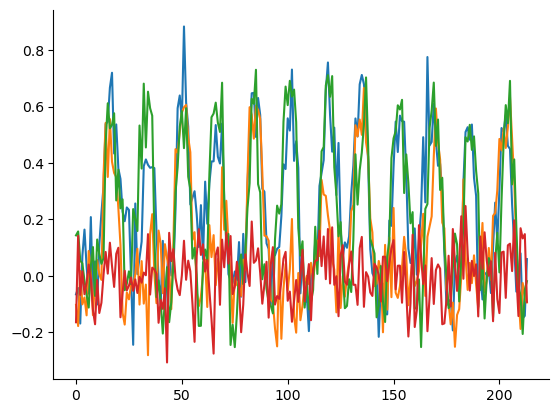

In [24]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [25]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 3, 10),    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, fixed_pars={'width_l' : 0.68})

Working with chunk size of 778816
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0001]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  parameters.loc[ix] = new_parameters.loc[ix]


*** Only fitting: ***
 * width_r
 * SFp
 * CSp
 * crf_exp
 * amplitude
 * baseline
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 4


Current R2: 0.62920/Best R2: 0.62920: 100%|██████████| 1000/1000 [00:04<00:00, 223.92it/s]


In [26]:
print(cfitter.get_rsq(refined_pars))

source
0    0.838961
1    0.814064
2    0.863782
3    0.000000
Name: r2, dtype: float32


In [197]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.65, 0.69],     # we fix width_l in our model
    'crf_exp'   : [0, 10] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-2,2]
}
fitter = BPRF(model, data)
fitter.add_priors_from_bounds(
    bounds, 
)
# fitter.add_bijector_from_bounds(
#     bounds, 
# )
for p in bounds.keys():
    if p == 'baseline':
        continue
    fitter.add_bijector(
        pid=p, bijector_type='softplus'
    )
fitter.prep_for_fitting()

init_pars = {
    'width_r' : np.ones(4) * 1,
    'SFp' : np.ones(4) * 1,
    'CSp' : np.ones(4) * 100,
    'width_l' : np.ones(4) * 0.68,
    'crf_exp' : np.ones(4) * 1,
    'amplitude' : np.ones(4) * 5, 
    'baseline' : np.ones(4) * 0, 
}
init_pars = pd.DataFrame(init_pars)

idx=0
fitter.fit(
    idx = idx,
    init_pars=refined_pars, 
    num_results=500,
)

[[ 1.44607949e+00  2.99453807e+00  1.83395233e+02  6.80000007e-01
   1.76217949e+00  9.86308038e-01  1.04784938e-02]
 [ 1.47886550e+00  9.72954035e-01  8.69229584e+01  6.80000007e-01
   1.87648857e+00  1.05201709e+00 -1.79349780e-02]
 [ 1.00660110e+00  3.96066904e+00  7.66485138e+01  6.80000007e-01
   3.06861854e+00  1.01699233e+00 -1.40433945e-02]
 [ 6.66666687e-01  0.00000000e+00  5.00000000e+01  6.80000007e-01
   9.99995172e-01  1.00000041e-04  7.92901265e-04]]
Gradient for parameter 0: [2.1979229e-06]
Gradient for parameter 1: [3.3664512e-06]
Gradient for parameter 2: [3.0734388e-06]
Gradient for parameter 3: [0.08073407]
Gradient for parameter 4: [1.937151e-07]
Gradient for parameter 5: [4.8428774e-07]
Gradient for parameter 6: [3.0841911e-06]
idx=[0]; initial_ll=[-207.97937], initial_prior=[-10.268131 -10.268131 -10.268131 -10.268131]


In [198]:
fitter.p_bijector

{'width_r': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'SFp': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'CSp': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'width_l': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'crf_exp': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'amplitude': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
 'baseline': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}

In [200]:
rsq = fitter.get_rsq_for_idx(
    idx=idx, parameters=fitter.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )
rsq


0      0.838961
1      0.838961
2      0.838961
3      0.830150
4      0.831534
         ...   
545    0.443265
546    0.251508
547    0.247237
548    0.247134
549    0.201460
Name: r2, Length: 550, dtype: float32

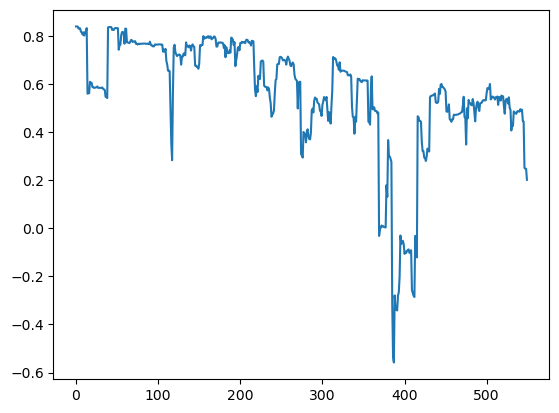

In [201]:
plt.plot(rsq)

,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
545,0.719511,5.176202,183.230835,0.688257,3.295621,1.238444,-0.110076


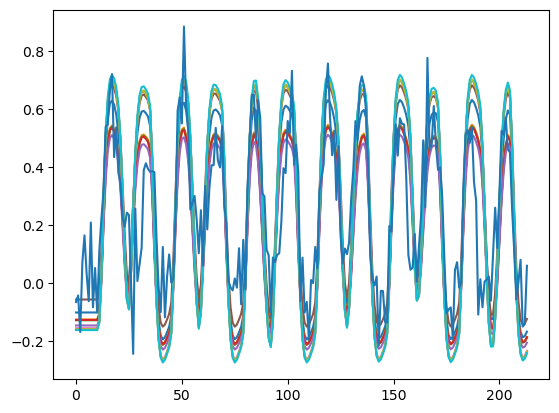

In [202]:
pred = fitter.get_predictions(
    parameters=fitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
id_start = 540
colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,id_start:],
    # c=colors,
)
plt.plot(data.iloc[:,0])
fitter.mcmc_sampler[idx].iloc[545:546,:]

/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_85516/693941783.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


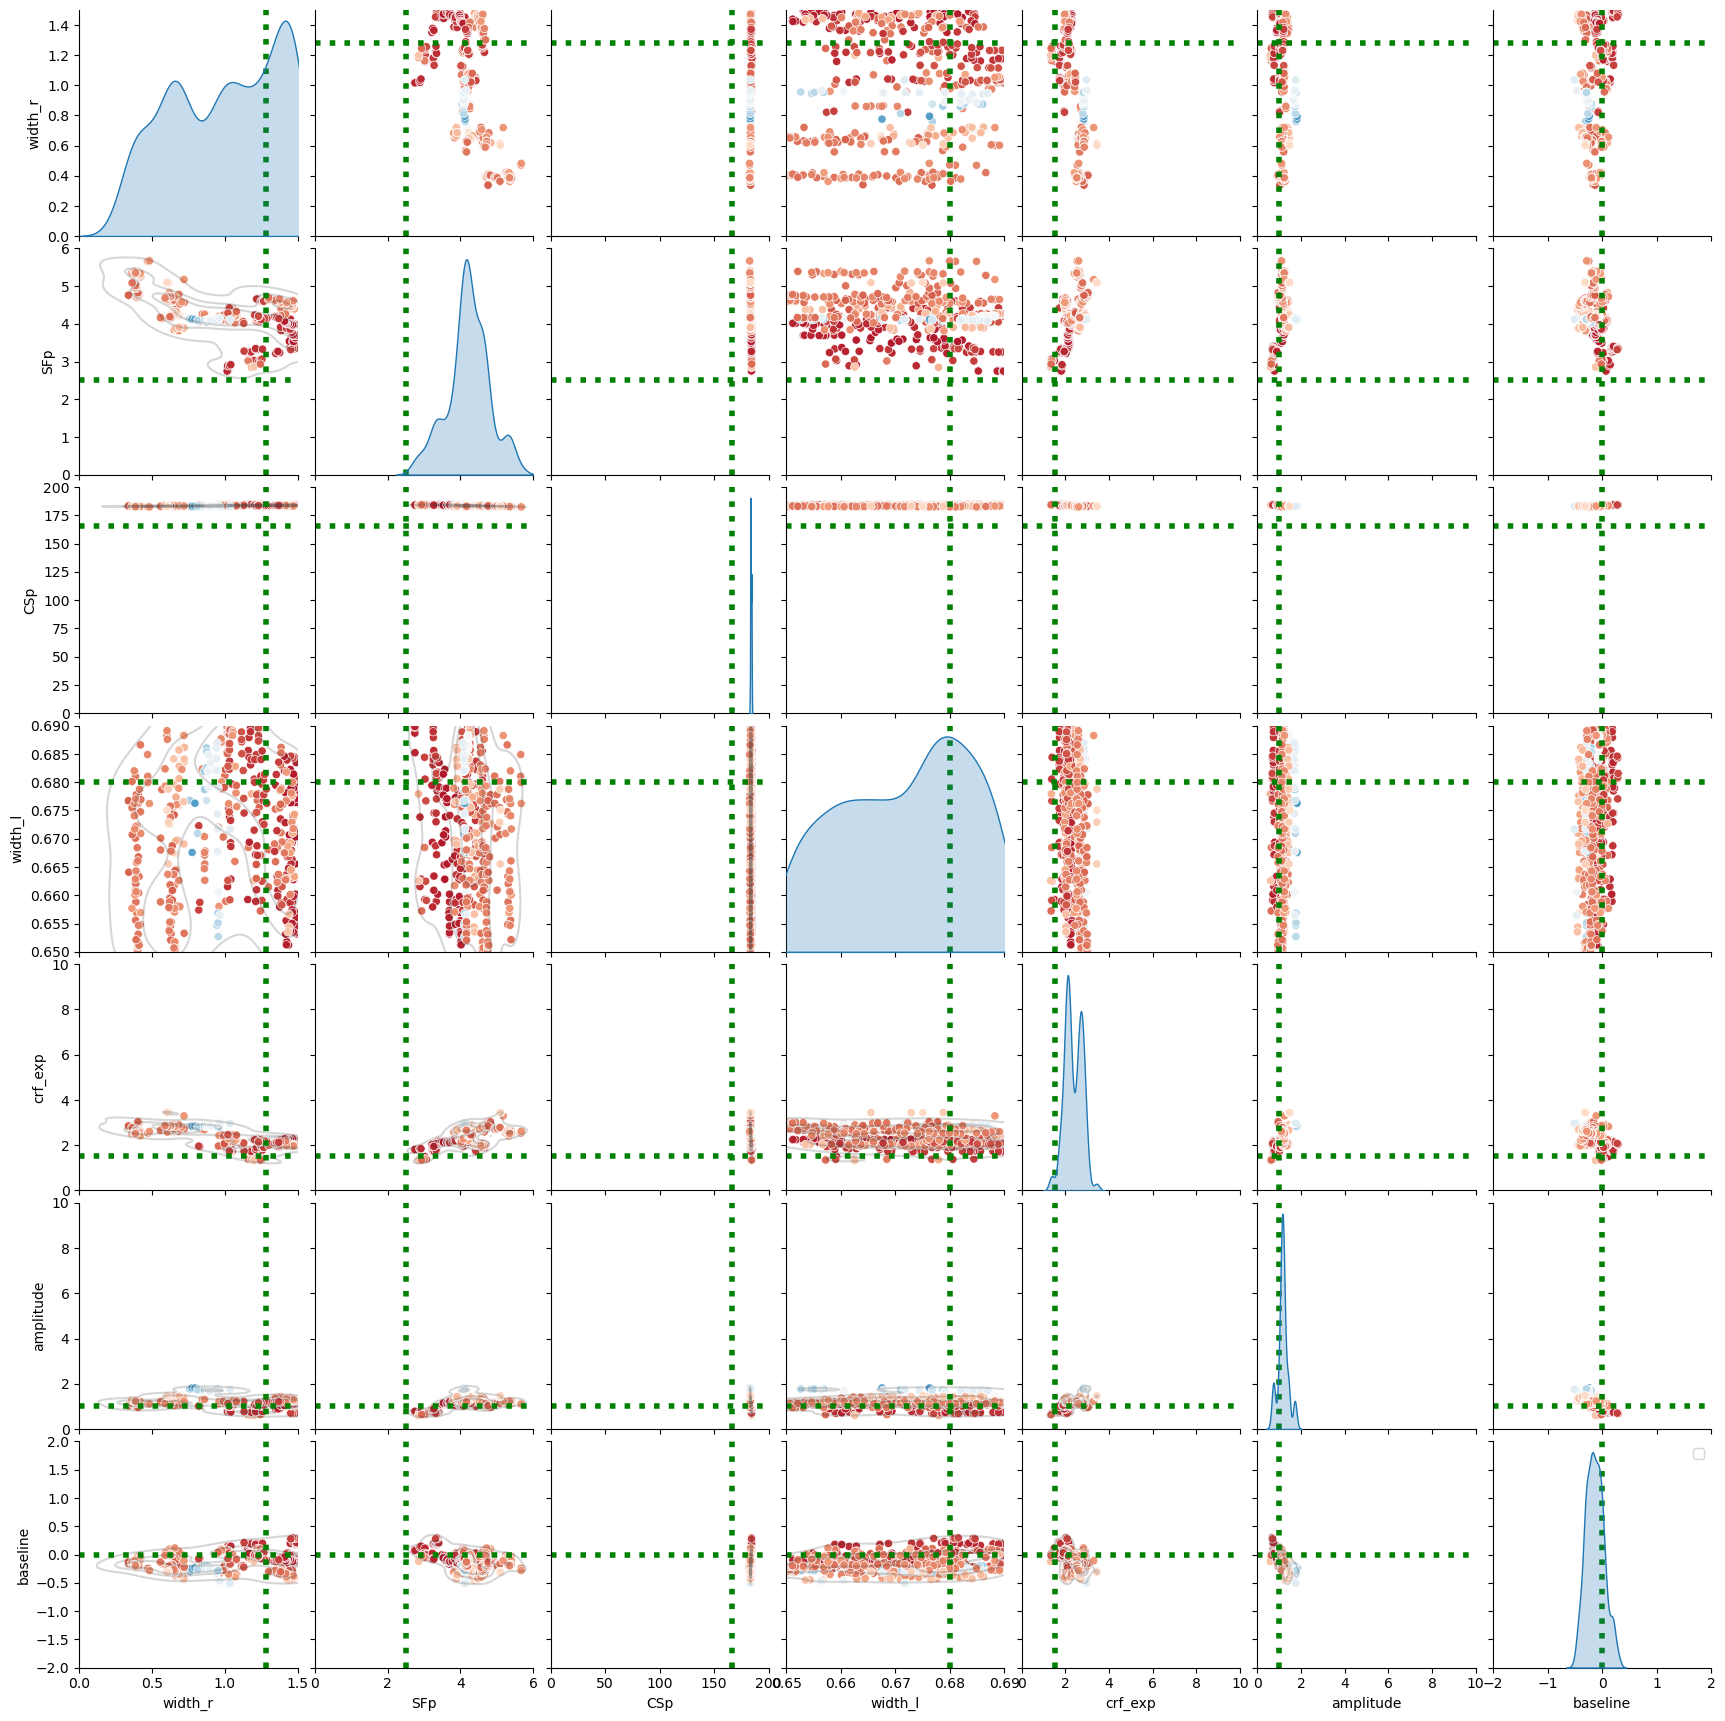

In [203]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    fitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
